In [1]:
import torch
from  torch.utils.data import Dataset, DataLoader
import os
from skimage import io, transform
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from PIL import Image
from torchvision.transforms import Resize, ToTensor, ToPILImage

In [3]:
!mkdir data
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -P data/

mkdir: cannot create directory ‘data’: File exists
--2020-04-21 15:55:36--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2020-04-21 15:55:37--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘data/VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M   278KB/s    in 24m 29s 

2020-04-21 16:20:10 (306 KB/s) - ‘data/VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

if use_cuda:
    torch.backends.cudnn.benchmark=True

device

device(type='cuda')

train size 4011
validation size 1000
X_small torch.Size([3, 72, 72])
Y_medium torch.Size([3, 144, 144])
Y_large torch.Size([3, 288, 288])
0 torch.Size([8, 3, 72, 72]) torch.Size([8, 3, 144, 144])
1 torch.Size([8, 3, 72, 72]) torch.Size([8, 3, 144, 144])
2 torch.Size([8, 3, 72, 72]) torch.Size([8, 3, 144, 144])
3 torch.Size([8, 3, 72, 72]) torch.Size([8, 3, 144, 144])


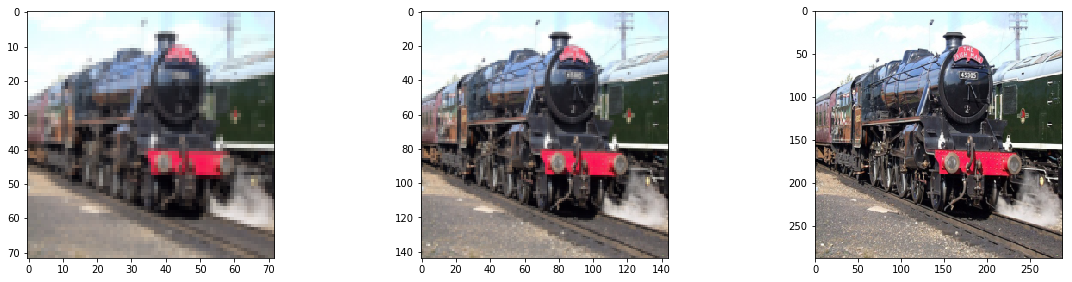

In [3]:
class PascalDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        files = [name for name in os.listdir(self.root_dir) if os.path.isfile('/'.join([self.root_dir, name]))]
        files.sort()
        self.files = files
        
    def __len__(self):
#         print(self.files)
        return len(self.files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.files[idx])
        image = Image.open(img_name).convert('RGB')
#         image = io.imread(img_name)

        return image
        
class TransformingDataset(Dataset):
        def __init__(self, ds, transforms, keys, start=0, end=None):
            self.ds = ds
            self.keys_transforms = list(zip(keys, transforms))
            self.start = start
            if not end:
                end = len(ds)
            self.end = end
            
        def __len__(self):
            return self.end - self.start
        
        def __getitem__(self, idx):
            it = self.ds[idx]
            return {name:f(it) for (name,f) in self.keys_transforms } 
#             return it, list(map(lambda f: f(it), self.transforms))
        
        def number_of_transforms(self):
            return len(self.keys_transforms)


ds = PascalDataset('data/VOCdevkit/VOC2007/JPEGImages')

# resizer = lambda output_shape: (lambda img: transform.resize(img, output_shape) )
resizer = lambda output_shape: lambda img: ToTensor()(Resize(output_shape)(img))


resize_large = resizer((288, 288))
resize_medium = resizer((144, 144))
resize_small = resizer((72, 72))


ds_small_medium_train = TransformingDataset(ds, [resize_small, resize_medium], 
                                            ['X_small', 'Y_medium'], start=1000)

ds_small_medium_val = TransformingDataset(ds, [resize_small, resize_medium], 
                                            ['X_small', 'Y_medium'], end=1000)

ds_small_medium_large = TransformingDataset(ds, [resize_small, resize_medium, resize_large], 
                                            ['X_small', 'Y_medium', 'Y_large'])

print('train size', len(ds_small_medium_train))
print('validation size', len(ds_small_medium_val))

# def present(idx, dataset):
#     plt.figure(figsize=(20,10))
#     columns = dataset.number_of_transforms()
#     data_dict = dataset[idx]
#     for i, transformation in enumerate(data_dict):
#         plt.subplot(len(data_dict) / columns + 1, columns, i + 1)
#         print(data_dict[transformation].shape)
#         plt.imshow(ToPILImage()(data_dict[transformation]))
        
        
def present(data_dict):
    plt.figure(figsize=(20,10))
    columns = len(data_dict)
    for i, transformation in enumerate(data_dict):
        plt.subplot(len(data_dict) / columns + 1, columns, i + 1)
        print(transformation, data_dict[transformation].shape)
        plt.imshow(ToPILImage()(data_dict[transformation]))
        
plt.show()

present(ds_small_medium_large[np.random.randint(len(ds))])

dataloader = DataLoader(ds_small_medium_train, batch_size=8, shuffle=True, num_workers=4)
val_dataloader = DataLoader(ds_small_medium_val, batch_size=8, shuffle=True, num_workers=4)


for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['X_small'].size(), sample_batched['Y_medium'].size())

    if i_batch == 3:
        break

In [10]:
class FirstModel(nn.Module):
    def __init__(self, out_channels, input_h_w=(72, 72), output_h_w=(144, 144)):
        super(FirstModel, self).__init__()
        self.input_h_w = input_h_w
        self.output_h_w = output_h_w
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=out_channels, padding = 1, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels, padding = 1, kernel_size=3)
        self.final_conv = nn.Conv2d(in_channels=out_channels,out_channels=3, padding = 1, kernel_size=3)
        self.act = F.relu

    def forward(self, x):
        x = x.view(-1, 3, self.input_h_w[0], self.input_h_w[1]).float()
#         print(x.shape)
        #torch.Size([B, 3, H, W])
        x = self.act(self.conv1(x))
#         print(x.shape)
        #torch.Size([B, s64, H, W])
        x = self.act(self.conv2(x))
#         print(x.shape)
        #torch.Size([B, 64, H, W])
        x = nn.functional.interpolate(x, size=self.output_h_w)#, mode='bilinear', align_corners=True)
#         print(x.shape)
#         x = self.act(x)
        x = self.final_conv(x)
        x = F.tanh(x)
        x = torch.add(x, 1.)
        x = torch.mul(x, 0.5)
#         x = self.act(x)
#         x = x - x.min()
#         x = x / x.max()
#         print(x.shape)
        return x

model = FirstModel(64).float()
model.to(device)


FirstModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (final_conv): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
def train(model, criterion, optimizer, dataloader, val_dataloader, device, epochs=35, data_key='X_small', target_key='Y_medium'):
    
    torch.cuda.empty_cache()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data_dict in enumerate(dataloader, 0):
            X = data_dict[data_key]
            Y = data_dict[target_key]
            Y = Y.float()
            optimizer.zero_grad()
            X = X.to(device)
            Y = Y.to(device)
            Y_pred = model(X)

            Y_pred = Y_pred.view(Y.shape)

            loss = criterion(Y_pred, Y)
            
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            if i and i % 1000 == 0:
                print(running_loss / 1000)
                running_loss = 0.0
        
        running_loss = 0.0
        model.eval()
        with torch.no_grad():
            for data_dict in val_dataloader:
                X = data_dict[data_key]
                Y = data_dict[target_key]
                Y = Y.float()
                X = X.to(device)
                Y = Y.to(device)
                Y_pred = model(X)
                Y_pred = Y_pred.view(Y.shape)

                loss = criterion(Y_pred, Y)
                running_loss += loss.item()
        print('Epoch', epoch + 1)
        print('Validation loss', running_loss / len(val_dataloader))
            

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, criterion, optimizer, dataloader, val_dataloader, device)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 1
Validation loss 0.03222302338480949
Epoch 2
Validation loss 0.012466111443936825
Epoch 3
Validation loss 0.010179378021508456
Epoch 4
Validation loss 0.008577574379742145
Epoch 5
Validation loss 0.0073175025507807735
Epoch 6
Validation loss 0.006429051093757153


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


43
small torch.Size([3, 72, 72])
medium torch.Size([3, 144, 144])
SR torch.Size([3, 144, 144])


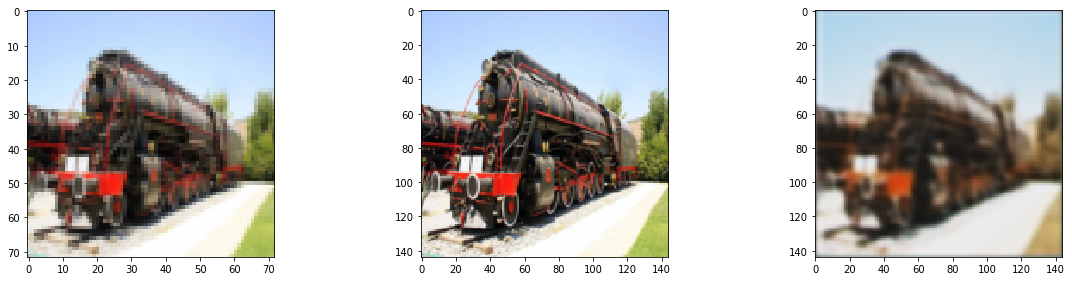

In [9]:
# ds_small_medium_val[0]
idx = np.random.randint(len(ds_small_medium_val))
idx = 43
model = model.eval()

small = ds_small_medium_val[idx]['X_small']

Y = model(small.to(device)).cpu().squeeze(0).float().detach()
# Y = np.clip(Y, 0, 1)

print(idx)

for pix in Y[:, 10:15, 10:15]:
#     print(pix)
    pass



medium = ds_small_medium_val[idx]['Y_medium']

present({ 'small': small, 'medium': medium, 'SR': Y})
plt.show()

In [85]:
for param in model.parameters():
    print(param.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([3, 64, 3, 3])
torch.Size([3])
